In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_04 import *

## Initial setup

In [3]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [7]:
data = DataBunch(DataLoader(train_ds, bs, shuffle=True), 
                 DataLoader(valid_ds, bs, shuffle=False), c)

In [14]:
#export
def create_learner(get_model, loss_func, data):
    model, opt = get_model(data)
    return Learner(model, opt, loss_func, data)

In [15]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

In [16]:
run.fit(3, learn)

train: [0.673299609375, tensor(0.8027)]
valid: [0.3140939208984375, tensor(0.9081)]
train: [0.297591484375, tensor(0.9147)]
valid: [0.2337046875, tensor(0.9330)]
train: [0.23768986328125, tensor(0.9322)]
valid: [0.2032789794921875, tensor(0.9429)]


In [17]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.768190078125, tensor(0.7994)]
valid: [0.3432261962890625, tensor(0.9054)]
train: [0.34472234375, tensor(0.9014)]
valid: [0.2874130859375, tensor(0.9197)]
train: [0.28978421875, tensor(0.9167)]
valid: [0.2525267578125, tensor(0.9308)]


In [43]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

In [112]:
class Recorder(Callback):
    def begin_fit(self): self.losses, self.lrs = [], []

    def after_batch(self):
        if not self.in_train: return
        self.losses.append(self.loss.detach().cpu())
        self.lrs.append(self.opt.param_groups[0]['lr'])

    def plot_lr(self): plt.plot(range(len(self.lrs)), self.lrs)
    def plot_loss(self): plt.plot(range(len(self.losses)), self.losses)

class ParamScheduler(Callback):
    _order = 0
    def __init__(self, sched): self.sched = sched

    def set_param(self, i):
        for pg in self.opt.param_groups:
            pg['lr'] = self.sched(i)
            
    def begin_batch(self):
        if self.in_train: self.set_param(self.n_epochs/self.epochs)

Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

In [103]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

We can refactor this with a decorator.

In [86]:
#export
def annealer(func):
    def _func(start, end): return partial(func, start, end)
    return _func

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [87]:
# shift-tab works too, in Jupyter!
# sched_lin()

In [88]:
f = sched_lin(1,2)
f(0.3)

1.3

And here are other scheduler functions:

In [89]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start*(end/start)**pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

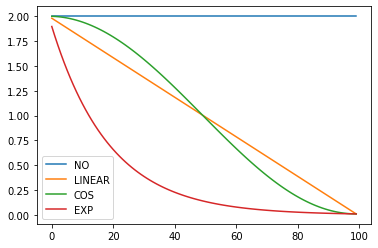

In [90]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [91]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [92]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

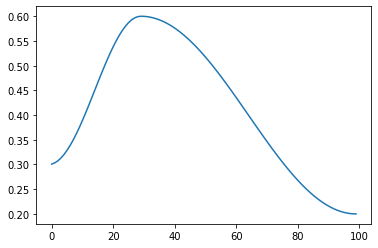

In [93]:
plt.plot(a, [sched(o) for o in p])

We can use it for training quite easily...

In [113]:
cbfs = [Recorder,
        partial(AvgStatsCallback, [accuracy]),
        partial(ParamScheduler, sched)]

In [114]:
learn = create_learner(get_model_func(lr=.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [115]:
run.fit(3, learn)

train: [0.77040140625, tensor(0.7903)]
valid: [0.315468115234375, tensor(0.9114)]
train: [0.30400490234375, tensor(0.9131)]
valid: [0.24639931640625, tensor(0.9274)]
train: [0.24545005859375, tensor(0.9297)]
valid: [0.2189452880859375, tensor(0.9383)]


In [83]:
TrainEvalCallback??

... then check with our recorder if the learning rate followed the right schedule.

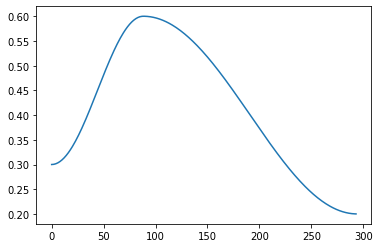

In [116]:
run.recorder.plot_lr()

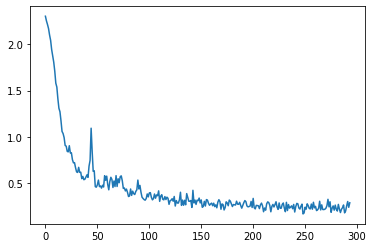

In [117]:
run.recorder.plot_loss()

## Discriminative learning rates

In [124]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [125]:
m = data.train_ds.x.shape[1]
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))

In [126]:
wgts,biases = [],[]

for l in model:
    if hasattr(l,'weight'): wgts.append(l.weight)
    if hasattr(l,'bias'  ): biases.append(l.bias  )

In [132]:
#export
def pg_dicts(pgs): return [{'params': pg} for pg in pgs]

In [133]:
pgs = pg_dicts((wgts,biases))
opt = optim.SGD(pgs, lr=0.1)
learn = Learner(model, opt, loss_func, data)

In [134]:
#export
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [ ]:
phases = [0.3, 0.7]
sched_w = combine_scheds(phases, cos_1cycle_anneal(0.3, 0.6, 0.2)) 
sched_b = combine_scheds(phases, cos_1cycle_anneal(0.9, 1.8, 0.6))

In [137]:
def create_scheds(phase1, sched, starts, highs, ends):
    phases = [phase1, 1 - phase1]
    return [
        combine_scheds(phases, cos_1cycle_anneal(s, h, e))
        for s, h, e in zip(starts, highs, ends)
    ]

In [138]:
scheds = create_scheds(0.3, sched_cos, (0.3,0.9), (0.6,1.8), (0.2,0.6))

In [142]:
cbfs = [Recorder,
        partial(AvgStatsCallback, [accuracy]),
        partial(ParamScheduler, pname='lr', sched_funcs=scheds)]

In [143]:
run = Runner(cb_funcs=cbfs)

In [144]:
run.fit(3, learn)

train: [0.7938165625, tensor(0.7811)]
valid: [0.361793359375, tensor(0.8945)]
train: [0.3073796484375, tensor(0.9083)]
valid: [0.2396543701171875, tensor(0.9310)]
train: [0.24066080078125, tensor(0.9306)]
valid: [0.2169534423828125, tensor(0.9398)]


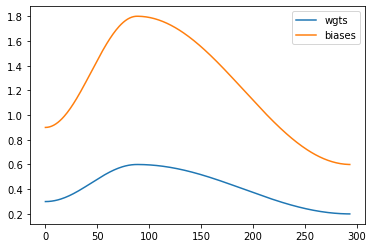

In [145]:
plt.plot(run.recorder.lrs[0])
plt.plot(run.recorder.lrs[1])
plt.legend(['wgts','biases']);

## Export

In [146]:
#!python notebook2script.py 05_anneal.ipynb